<a href="https://colab.research.google.com/github/mirzarad/CSE308/blob/master/Neighbors_geoprocesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install geopandas

In [0]:
!pip install rtree

In [0]:
! pip install pyshp
! pip install pyproj
! pip install geopy

In [0]:
!pip install fiona

In [0]:
!pip install https://github.com/JosPolfliet/pandas-profiling/archive/master.zip

!pip install https://github.com/andrea-cuttone/geoplotlib/archive/master.zip

!pip install https://github.com/ResidentMario/missingno/archive/master.zip

In [8]:
from google.colab import files
uploaded = files.upload()

Saving VTDs_Oct17.zip to VTDs_Oct17.zip


In [0]:
import geopandas as gpd


In [0]:
!unzip /content/VTDs_Oct17.zip

In [0]:
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

In [0]:
import os

In [0]:
os.chdir("/content/spatialindex-src-1.8.5")

In [0]:
!./configure

In [0]:
!make

In [0]:
!make install

In [0]:
!ldconfig

In [0]:
import geopandas as gpd

In [0]:
import shapely as shp

In [0]:
!pip install more-itertools

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9152 entries, 0 to 9151
Data columns (total 47 columns):
OBJECTID_1    9152 non-null int64
OBJECTID      9152 non-null int64
NAMELSAD      9152 non-null object
CORRECTSTF    9150 non-null object
TAPERSONS     9152 non-null int64
TA1RACE       9152 non-null int64
TAWHITEALN    9152 non-null int64
TABLACKALN    9152 non-null int64
TAAMINDALN    9152 non-null int64
TAASIANALN    9152 non-null int64
TANHPOALN     9152 non-null int64
TAOTHERALN    9152 non-null int64
TA2RACE       9152 non-null int64
TAHISPANIC    9152 non-null int64
VAPERSONS     9152 non-null int64
VA1RACE       9152 non-null int64
VAWHITEALN    9152 non-null int64
VABLACKALN    9152 non-null int64
VAAIANALN     9152 non-null int64
VAASIANALN    9152 non-null int64
VANHPOALN     9152 non-null int64
VAHISPANIC    9152 non-null int64
VANHISPANC    9152 non-null int64
COUNTYNAME    9152 non-null object
MCD_NAME      9152 non-null object
VTD_NAME      7628 non-null obj

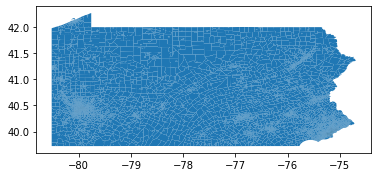

In [20]:


%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


shp_file = '/content/VTDs_Oct17.dbf'

geom = gpd.read_file(shp_file)

geom.info()

geom.plot()


In [21]:
geom.geometry.nunique()

9152

In [0]:
geom.insert(0, 'ID', range(0, len(geom)))

In [0]:
geom.head()

,OBJECTID_1,OBJECTID,NAMELSAD,CORRECTSTF,TAPERSONS,TA1RACE,TAWHITEALN,TABLACKALN,TAAMINDALN,TAASIANALN,TANHPOALN,TAOTHERALN,TA2RACE,TAHISPANIC,VAPERSONS,VA1RACE,VAWHITEALN,VABLACKALN,VAAIANALN,VAASIANALN,VANHPOALN,VAHISPANIC,VANHISPANC,COUNTYNAME,MCD_NAME,VTD_NAME,T16DEM,T16REP,T16OTH,T16PRESD,T16PRESR,T16PRESOTH,T16SEND,T16SENR,T16ATGD,T16ATGR,T16AUDD,T16AUDR,T16TREASD,T16TREASR,T16CONGD,T16CONGR,T16STSD,T16STSR,T16STHD,T16STHR,geometry
0,0,0,SEVEN SPRINGS,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fayette,Seven Springs,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-79.29632 40.03651, -79.29680 40.035..."
1,0,0,ASHLAND,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Columbia,Ashland,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-76.36468 40.78115, -76.36482 40.781..."
2,3,3,RICHLAND TWP Voting District-Psudo (Emlenton B...,420310400-P1,8,8,8,0,0,0,0,0,0,0,8,8,8,0,0,0,0,0,0,Clarion,Emlenton,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-79.69325 41.18306, -79.69329 ..."
3,4,4,ALLEGHENY TWP DIST 04 - Psudo (Tunnelhill Boro...,420130040-P1,118,118,114,0,0,4,0,0,0,0,118,118,114,0,0,4,0,0,0,Blair,Tunnel Hill,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-78.54201 40.46965, -78.54200 40.469..."
4,5,5,WEST SADSBURY TWP Voting District,420291740,2444,2414,2247,123,2,10,0,32,30,59,1737,1724,1600,96,2,7,0,36,1701,Chester,West Sadsbury Twp,None,420,690,176,334,562,34,317,571,334,588,288,540,326,532,289,622,354,568,0,707,"POLYGON ((-75.93793 40.00867, -75.93794 40.008..."


In [0]:
type(geom)
geom.head()

Geospatial anaysis using fiona
open file 
Find The coordinate reference system (CRS) (for future transformations)

In [0]:
import fiona as fiona
import itertools
import pyproj
from pprint import pprint
from shapely.geometry import shape, mapping
from shapely.ops import transform
from functools import partial

polys = fiona.open("/content/VTDs_Oct17.shp")
print(type(polys))
print(polys.schema)

<class 'fiona.collection.Collection'>
{'properties': OrderedDict([('OBJECTID_1', 'int:10'), ('OBJECTID', 'int:10'), ('NAMELSAD', 'str:254'), ('CORRECTSTF', 'str:254'), ('TAPERSONS', 'int:10'), ('TA1RACE', 'int:10'), ('TAWHITEALN', 'int:10'), ('TABLACKALN', 'int:10'), ('TAAMINDALN', 'int:10'), ('TAASIANALN', 'int:10'), ('TANHPOALN', 'int:10'), ('TAOTHERALN', 'int:10'), ('TA2RACE', 'int:10'), ('TAHISPANIC', 'int:10'), ('VAPERSONS', 'int:10'), ('VA1RACE', 'int:10'), ('VAWHITEALN', 'int:10'), ('VABLACKALN', 'int:10'), ('VAAIANALN', 'int:10'), ('VAASIANALN', 'int:10'), ('VANHPOALN', 'int:10'), ('VAHISPANIC', 'int:10'), ('VANHISPANC', 'int:10'), ('COUNTYNAME', 'str:254'), ('MCD_NAME', 'str:254'), ('VTD_NAME', 'str:254'), ('T16DEM', 'int:10'), ('T16REP', 'int:10'), ('T16OTH', 'int:10'), ('T16PRESD', 'int:10'), ('T16PRESR', 'int:10'), ('T16PRESOTH', 'int:10'), ('T16SEND', 'int:10'), ('T16SENR', 'int:10'), ('T16ATGD', 'int:10'), ('T16ATGR', 'int:10'), ('T16AUDD', 'int:10'), ('T16AUDR', 'int:10'

The algorithm looks at all combinations of geomety object (O(rn))
if the geometry share border (not interior)and length of the shared line is greater than predifined threshold of 100 meters
we add the edge to the graph

In [0]:
def findNeighbPrecincts(polys){
newschema = {'geometry': 'LineString','properties': {'id1':'str', 'id2':'str', 'length':'float'}}
with fiona.open('intersection.shp','w', crs=polys.crs, driver='ESRI Shapefile', schema=newschema) as e:
  for precinct1,precinct2 in  itertools.combinations(polys, 2):
    geomprecinct1 = shape(precinct1['geometry'])
    geomprecinct2 = shape(precinct2['geometry'])
    if !geomprecinct1.disjoint( geomprecinct2 ):
      id1 = precinct1['properties']['CORRECTSTF']
      id2 = precinct2['properties']['CORRECTSTF']
      project = partial(
      pyproj.transform,
      pyproj.Proj(init='EPSG:4326'),
      pyproj.Proj(init='EPSG:32633'))
      line = transform(project,shape(mapping(geomprecinct1.intersection(geomprecinct2))) )
      length=line.length
        if length>=100:
          e.write({'geometry':mapping(geomprecinct1.intersection(geomprecinct2)),  'properties': {'id1':id1, 'id2':id2, 'length':length}})
          print ("Precinct ", precinct1['properties']['CORRECTSTF'],  " touches Precinct ", precinct2['properties']['CORRECTSTF'], ", length of border: ", length)}